In [21]:
import numpy as np
import time
import Levenshtein as lev
import os
from annchor.datasets import load_strings
from annchor import compare_neighbor_graphs
from matplotlib import pyplot as plt




k=15

def levdist(a,b):
    return lev.distance(a,b)

strings_data = load_strings()
X = strings_data['X']
y = strings_data['y']
neighbor_graph = strings_data['neighbor_graph']

nx = X.shape[0]

for x in X[2::80]:
    print(x[:80]+'...')
    

ncuiojfanssruogqkshnfxxprvojrdttjiukneoeamhlkkymvxllovhujdiwdxlvrpsugdrqufzhjqsl...
vuibwocnosugldwsbxtxddpzrvojrgtutjiaufefamhsflkyvklpqvyhndiwdxxlvhrfrqvfzglfpnba...
cuiojfsosugdwsjxxpgjffnuuttjiaunknenxmmhljkklaimvolwvhjdwdlvrpslrqupfzhnglbwnnbh...
aciwcmomzflwzeskaptzwadcuyepovxdreytovrnzbgqyxoaaohmhoafqcsyjapkbsqrorinygsyodtu...
wcytocmfcsuvwvskptzdyeojkwdidrcwbovnbgpxpayjdwjhbfqcsydabqkzdgsqyorilnygisdsvdyt...
vuijuduxdhdwjesvvwfdwwhpsygrshchxcgnmtgviubjfybvzjtmtueellwfidzlomkfgrbidbamknir...
iejmbuguxahesvvwdgyasygrztckxcsgkrmtuvubjqjlzmueallwljjdqzlolcmkfglwrnebbidtakfy...
vzikmbjcuxkghdjexsvvwbwgyaxnsyrzhkxcglmtqvibjvqvyzjybuealfjdqelomkifkplbadtamyij...
yhmksxkbemmebhfdgktakkjjtoccnicxgarqjxuoraitooebaiqybofswgnyjmuuyiiqalbmvsgywvkj...
ojdmctzjxkezbwhdugkkkjjztbxnrzsxsravbooebaiyocwgzyluywiiaegljosukjziztvujbakfgcr...
tyizotyywjzdpwzodfurcyltqgurkebzbyoyppipnqlnrluutdovsygaboctfbwqixcaetcdalfgsayo...
teoftbykwomdftpzodvznqyltazremyypypapynqtzqnrqtmutdshebkboctwwfbwwtcbeactwcb

In [2]:
from numba import njit,prange

def get_new_bounds(ann):
    II,JJ = np.meshgrid(np.arange(ann.nx),np.arange(ann.nx))
    newD = ann.RefineApprox.copy()
    newD[II>JJ]*=(~ann.not_computed_mask)
    newD[II>JJ]-=ann.not_computed_mask
    newD[II<JJ]*=0
    newD+=newD.T


    @njit
    def get_approx(D,A,nx):
        Approx = np.zeros(shape=(nx, nx,2))
        DaD =  np.zeros(shape=(nx, nx))
        for i in prange(nx-1):
            imask = D[i]>-1
            #for a in A:
            #    imask[a]=False
            for j in prange(i+1,nx):
                mask = imask*(D[j]>-1)
                #mask[ann.A]=False

                djm = D[j][mask]
                dim = D[i][mask]

                lb = np.max(np.abs(dim - djm))
                ub = np.min(dim+djm)

                DaD[i,j] = (dim[np.argmin(djm)]+
                      djm[np.argmin(dim)])

                Approx[i,j,0] = lb
                Approx[j,i,0] = lb
                Approx[i, j, 1] = ub
                Approx[j,i,1] = ub

        return Approx,DaD/2

    return get_approx(newD,ann.A,ann.nx)

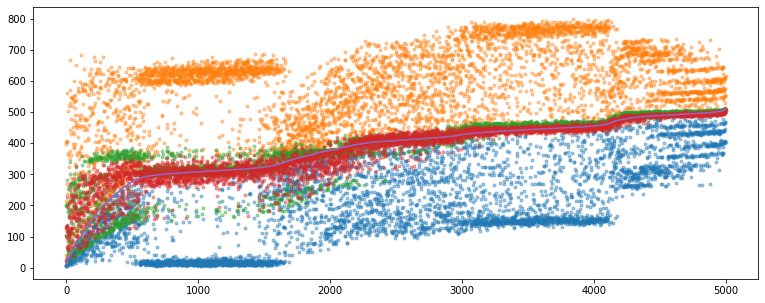

309.21574310136134


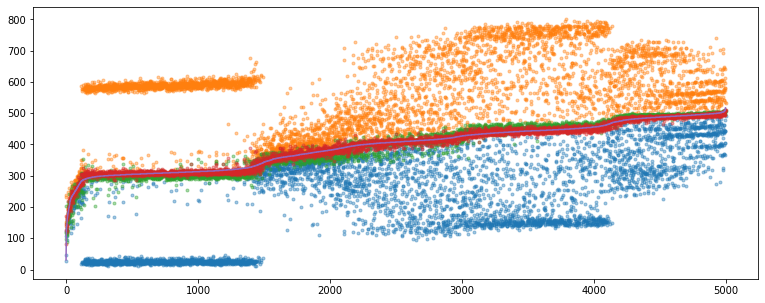

ANNchor Time: 40.296 seconds
ANNchor Accuracy: 15 incorrect NN pairs (0.062%)
ANNchor Evals: 158504 function calls (12.391% of brute force)


In [20]:
from annchor import Annchor

start_time = time.time()
ann = Annchor(X,
              levdist,
              n_anchors=23,
              n_neighbors=k,
              random_seed=5,
              n_samples=5000,
              refine_cycles=1,
              p_work=0.12)


ann.get_anchors()
ann.get_features()
ann.get_sample()
ann.fit_predict_regression()

fig,ax = plt.subplots(figsize=(13,5))
iy = np.argsort(ann.sample_y)
ax.plot(ann.sample_features[iy,2:5],'.',alpha=0.4)
ax.plot(ann.sample_predict[iy],'.',alpha=0.4)
ax.plot(ann.sample_y[iy])
plt.show()

ann.fit_predict_errors()
ann.select_candidate_pairs(0.5)
ann.refine_approx()

if True:
    II,JJ = np.meshgrid(np.arange(ann.nx),np.arange(ann.nx))


    #RA = ann.RefineApprox.copy()
    appr,dad = get_new_bounds(ann)
    ann.features[:,2:4]=appr[II>JJ]
    ann.features[:,4]=dad[II>JJ]


    ann.get_sample()
    ann.fit_predict_regression()
    ann.fit_predict_errors()
    #ann.RefineApprox = RA.copy()
    #for sample_ij,y in zip(ann.sample_ijs,ann.sample_y):
    #    i,j = sample_ij
    #    ann.RefineApprox[i,j]=y
    #    ann.RefineApprox[j,i]=y

    fig,ax = plt.subplots(figsize=(13,5))
    iy = np.argsort(ann.sample_y)
    ax.plot(ann.sample_features[iy,2:5],'.',alpha=0.4)
    ax.plot(ann.sample_predict[iy],'.',alpha=0.4)
    ax.plot(ann.sample_y[iy])
    plt.show()


ann.select_candidate_pairs(0.5)
ann.refine_approx()
#ann.select_candidate_pairs(0.45)
#ann.refine_approx()
ann.get_ann()
print('ANNchor Time: %5.3f seconds' % (time.time()-start_time))


## Test accuracy
error = compare_neighbor_graphs(neighbor_graph,
                                ann.neighbor_graph,
                                k)
print('ANNchor Accuracy: %d incorrect NN pairs (%5.3f%%)' % (error,100*error/(k*nx)))
print('ANNchor Evals: %d function calls (%5.3f%% of brute force)' % (ann.evals,
                                                       100*ann.evals/(ann.nx*(ann.nx-1)/2)
                                                      )
     )

##

In [7]:
ann.RefineApprox[0,131]

316.99841600755656

In [8]:
for i in range(ann.nx):
    if not (set(ann.neighbor_graph[1][i])==set(neighbor_graph[1][i][:15])):
        print(i)

0
3
6
7
8
10
12
16
17
19
27
29
30
35
36
37
39
40
41
42
44
45
46
48
52
53
54
56
57
59
60
62
65
66
67
68
70
71
72
74
75
76
77
78
82
84
87
88
89
91
92
94
95
96
98
99
100
101
103
108
109
114
115
116
117
118
121
123
125
126
128
130
131
132
133
135
136
142
144
145
150
151
155
157
161
162
163
166
167
171
172
174
175
176
177
182
183
185
186
188
190
193
196
197
198
202
205
206
207
208
209
210
213
214
215
216
217
218
220
221
222
225
227
228
229
230
231
232
233
236
237
238
239
241
242
243
245
246
247
249
250
251
252
253
254
255
257
258
261
263
265
266
267
268
269
270
271
272
274
275
276
277
278
283
284
287
288
290
291
292
295
296
297
300
301
304
305
307
308
309
310
311
312
313
314
315
316
318
319
320
321
323
324
325
329
332
333
334
337
338
339
342
343
344
345
346
347
349
350
351
352
354
355
356
357
358
359
361
362
363
364
366
368
371
372
374
375
376
378
381
383
384
385
387
391
392
393
395
396
398
400
402
403
405
406
407
408
409
411
412
413
414
415
416
417
420
421
423
424
425
426
427
428
429
431
4

In [9]:
ann.neighbor_graph[0][0][:15],ann.neighbor_graph[1][0][:15]

(array([  0, 130,  39, 140,  72, 143, 190,  90,  21, 142, 126, 100, 151,
         97, 170]),
 array([  0., 288., 295., 298., 299., 301., 301., 302., 302., 302., 303.,
        303., 303., 303., 303.]))

In [12]:
neighbor_graph[0][0][:15],neighbor_graph[1][0][:15]

(array([  0, 130,  39, 140,  72, 113,  78,  99,  66, 143, 131, 190,  75,
         90, 142]),
 array([  0, 288, 295, 298, 299, 299, 300, 300, 301, 301, 301, 301, 302,
        302, 302]))

In [13]:
a,b=0,113
ann.RefineApprox[a,b]
mask = (ann.features[:,0]==b)*(ann.features[:,1]==a)
ann.features[mask],ann.f(ann.X[a],ann.X[b]),ann.pred[mask],ann.RefineApprox[a,b],ann.not_computed_mask[mask]

(array([[113.,   0.,  32., 599., 307.,   0.]]),
 299,
 array([316.53868472]),
 316.53868472404235,
 array([ True]))

In [ ]:
self = ann
c = self.RefineApprox[II>JJ][~self.not_computed_mask]
nc = self.pred[self.not_computed_mask]
e = np.zeros(shape=self.N)
e[self.not_computed_mask] = nc
e[~self.not_computed_mask] = c
RA = np.zeros(shape=(self.nx,self.nx))
RA[II>JJ] = e
RA += RA.T

In [ ]:
ann.sample_ijs[ann.sample_ijs[:,1]==20]

In [ ]:
ann.RefineApprox

In [ ]:
ann.RefineApprox[II>JJ]

In [ ]:
c = ann.RefineApprox[II>JJ][~ann.not_computed_mask]
nc = ann.pred[ann.not_computed_mask]
nc.shape,c.shape

In [ ]:
e = np.zeros(shape=ann.N)
e[ann.not_computed_mask] = nc
e[~ann.not_computed_mask] = c
e.shape

In [ ]:
ann.not_computed_mask[(ann.features[:,0]==3)*(ann.features[:,1]==1)]

In [ ]:
ann.sample_ixs[ann.sample_ijs[:,1]==1]

In [ ]:
ann.features[1600],ann.LRApprox[1,3],ann.RefineApprox[1,3],ann.f(ann.X[1],ann.X[3])

In [ ]:
ann.get_ann()
ann.neighbor_graph[1][1][1]

In [ ]:
fig,ax = plt.subplots()
ax.hist(ann.features[ann.not_computed_mask][:,4],bins=100)
ax.set_yscale('log')
plt.show()

In [ ]:
np.argsort(ann.D,axis=1)[500:1000]

In [ ]:
Counter(np.argmin(ann.D,axis=1))

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))
ax.vlines([i*714 for i in range(8)],0,2.5,'k')
ix = np.argsort(ann.sample_y)
ax.plot(ann.sample_features[ix,2:-1],'.',alpha=0.3)
ax.plot(ann.sample_features[ix,4]/2,'.',alpha=0.3)


ax.plot(ann.sample_predict[ix],'.',alpha=0.3)
ax.plot(ann.sample_y[ix],'.',alpha=0.3)





In [ ]:
class NewAnchorPicker:
    
    def __init__(self):
        pass
    
    def init_ann(self,ann):
        self.ann = ann
        
    def get_anchors(self):
        ann= self.ann
        nx = ann.nx
        na = ann.n_anchors

        np.random.seed(ann.random_seed)

        # D stores distances to anchor points
        # note: at this point D is shape (n_anchors, nx),
        #       but we transpose this after calculations.
        D = np.zeros((na, nx)) + np.infty

        # A stores anchor indices
        A = np.zeros(na).astype(int)
        ix = np.random.randint(nx)

        #get_dists = get_dists_(ann.f,ann.low_cpu)
        S = {ix}
        for i in tq(range(na)):
            A[i] = ix  
            D[i] = get_dists(ix,ann.f,ann.X,nx)
            amins = np.argmin(D,axis=0)
            most_common_ix = Counter(amins).most_common()[0][0]

            ix = np.random.choice(list(set(np.arange(ann.nx)[amins==most_common_ix]).difference(S)))
            S=S.union({ix})


            
        return A,D.T,na*nx

In [ ]:
from annchor.utils import *
get_dists = get_dists_(ann.f,ann.low_cpu)

In [ ]:
from tqdm.notebook import tqdm as tq
nx = ann.nx
na = 23
np.random.seed(ann.random_seed)

# D stores distances to anchor points
# note: at this point D is shape (n_anchors, nx),
#       but we transpose this after calculations.
D = np.zeros((na, nx)) + np.infty

# A stores anchor indices
A = np.zeros(na).astype(int)
ix = np.random.randint(nx)

#get_dists = get_dists_(ann.f,ann.low_cpu)
S = {ix}
for i in tq(range(na)):
    A[i] = ix  
    D[i] = get_dists(ix,ann.f,ann.X,nx)
    amins = np.argmin(D,axis=0)
    most_common_ix = Counter(amins).most_common()[0][0]
    
    ix = np.random.choice(list(set(np.arange(ann.nx)[amins==most_common_ix]).difference(S)))
    S=S.union({ix})






In [ ]:
Counter(np.argmin(D,axis=0))

In [ ]:
S

In [ ]:
ann.features[:,0]==999

In [ ]:
from sklearn.decomposition import PCA
from umap import UMAP

In [ ]:
pca=PCA(n_components=5)

In [ ]:
T=pca.fit_transform(ann.LRApprox)

In [ ]:
ann.pred.shape

In [ ]:
ti = ann.D[ann.features[:,0].astype(int)]
tj = ann.D[ann.features[:,1].astype(int)]

In [ ]:
ldist = np.linalg.norm(ti-tj,axis=1)


In [ ]:
ldist[ann.sample_ixs]

In [ ]:
from sklearn.linear_model import LinearRegression as LR

lr = LR()

In [ ]:
sample_feat = np.vstack([ann.sample_predict,ldist[ann.sample_ixs].T]).T

In [ ]:
sample_feat,ann.sample_y

In [ ]:
lr.fit(sample_feat,ann.sample_y)

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))
y = ann.sample_y
iy = np.argsort(y)
x = ann.sample_predict
ax.plot(np.abs(x[iy]-lr.predict(sample_feat)[iy]),'.',alpha=0.6)

#ax.plot(np.abs(lr.predict(sample_feat)[iy]-y[iy]),'.',alpha=0.6)


#ax.plot(y[iy])



In [ ]:
lr.